## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data, id, expy2

import numpy as np
import torch
from torch.optim import Adam
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# # Load the dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
# data = pd.read_excel(url)

# # The last two columns are the target variables (Heating Load and Cooling Load)
# X = data.iloc[:, :-2].values  # Covariates
# y = data.iloc[:, -2].values  # Heating Load
# dataset = 'energy'

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
dataset = 'wine'

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


## Reparametrization attack

In [8]:
def reparametrization_trick(x_adv, model, G, samples_per_iteration, func):
    # Sample from the model's predictive distribution keeping the gradient flow by using rsample
    y_samples = model.get_predictive_distribution(x_adv.unsqueeze(1)).rsample((samples_per_iteration,))
    
    # Using autograd to compute the gradients
    f_values = func(x_adv, y_samples)
    loss = ((f_values - G) ** 2).mean()
    loss.backward()
    
    return x_adv.grad, f_values.mean(), loss

In [9]:
def true_gradient_mean(x_adv, model, G):
    # The true gradient of the mean of the predictive distribution
    beta_dot_x = model.mu @ x_adv
    return 2 * (beta_dot_x - G) * model.mu

Text(0.5, 0, 'Log10(Samples)')

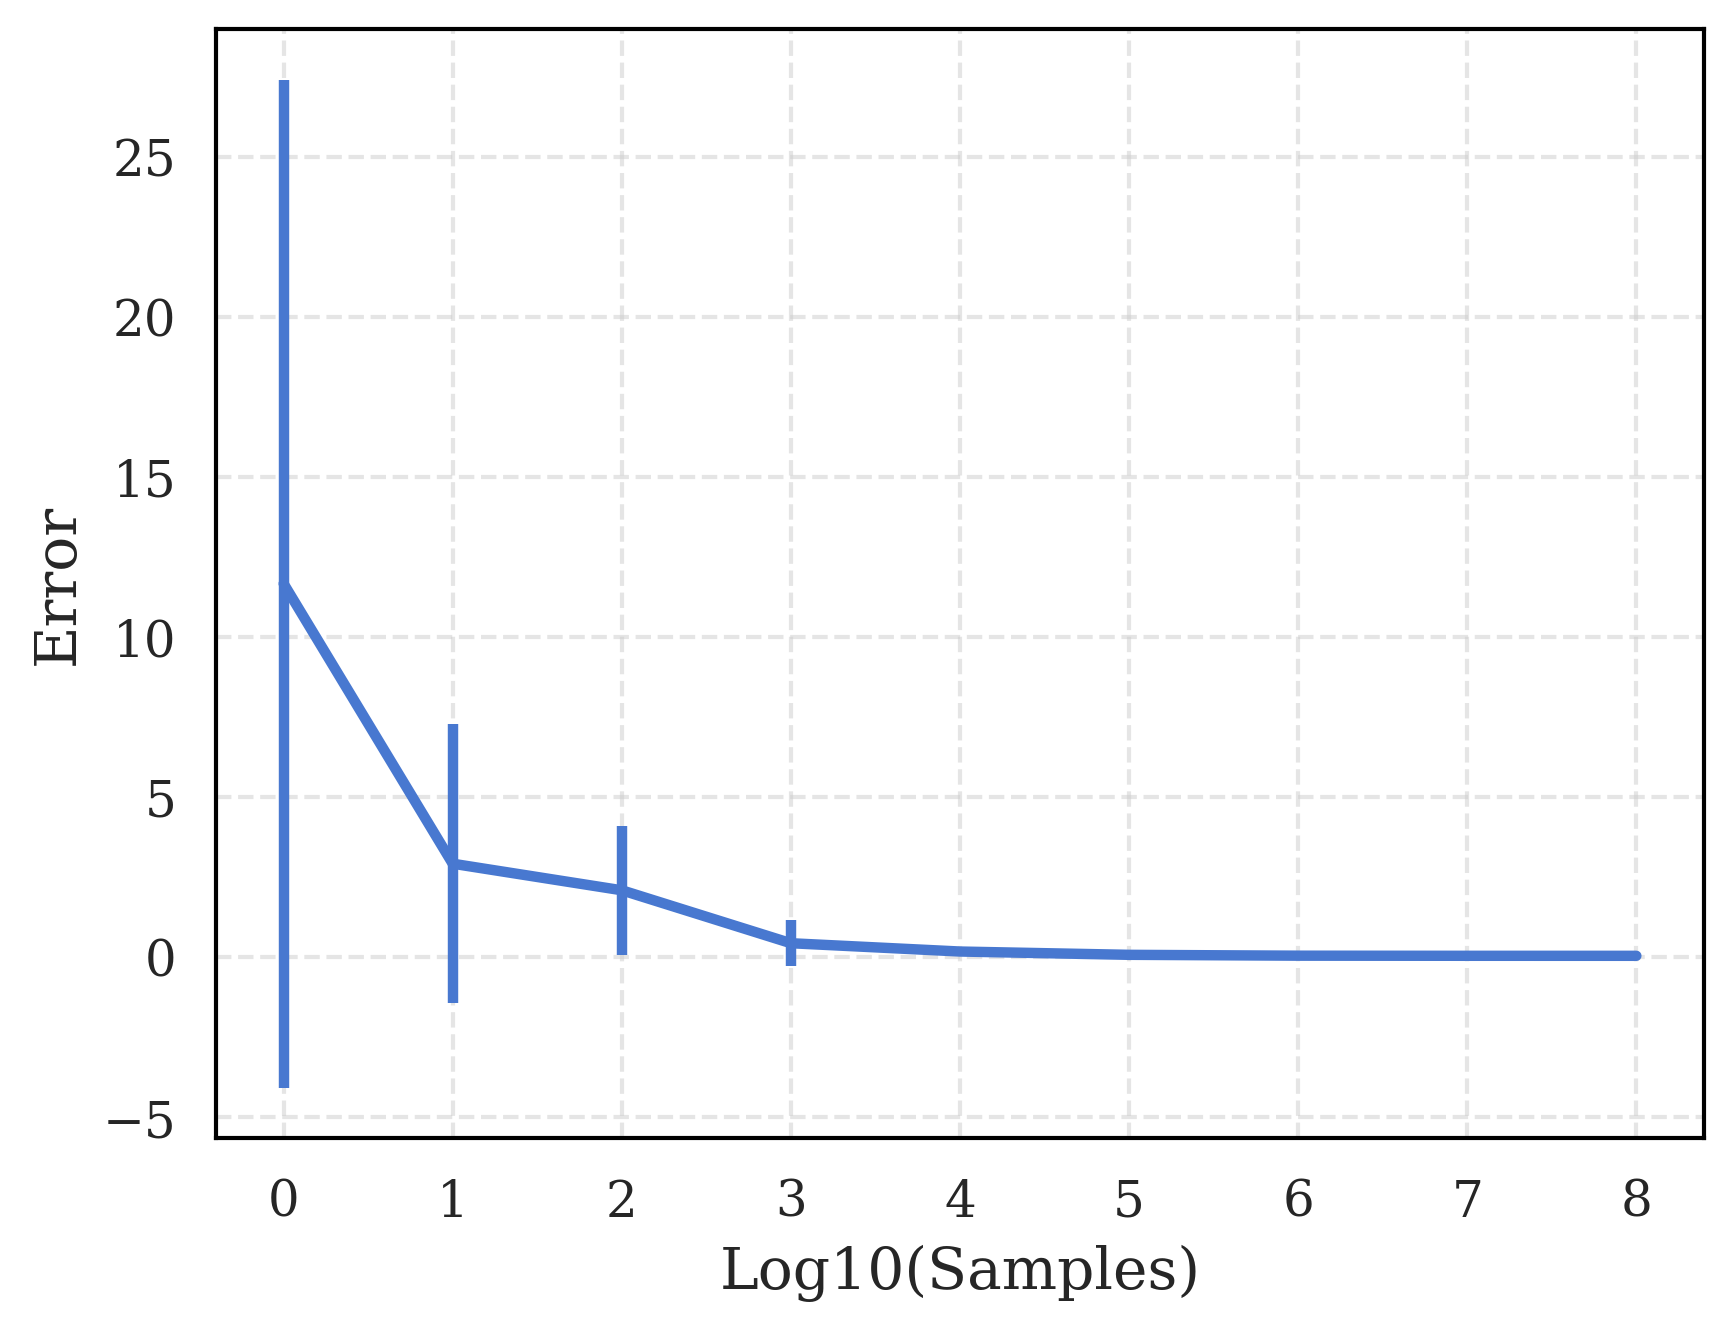

In [10]:
# Vemos como funciona la aproximacion del gradiente segun el numero de samples de reparametrization trick
diffs_total = []
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)

for _ in range(10):
    diffs = []

    exact_gradient = true_gradient_mean(x_adv, model, 3)
    for samples in range(9):
        rep_gradients, _, _ = reparametrization_trick(x_adv, model, 3, 10 ** samples, id)
        diffs.append(torch.norm(rep_gradients - exact_gradient).item())
        x_adv.grad.zero_()
    diffs_total.append(diffs)

# plot the mean and std of the losses
plt.errorbar(range(9), np.mean(diffs_total, axis=0), yerr=2*np.std(diffs_total, axis=0))
plt.ylabel('Error')
plt.xlabel('Log10(Samples)')

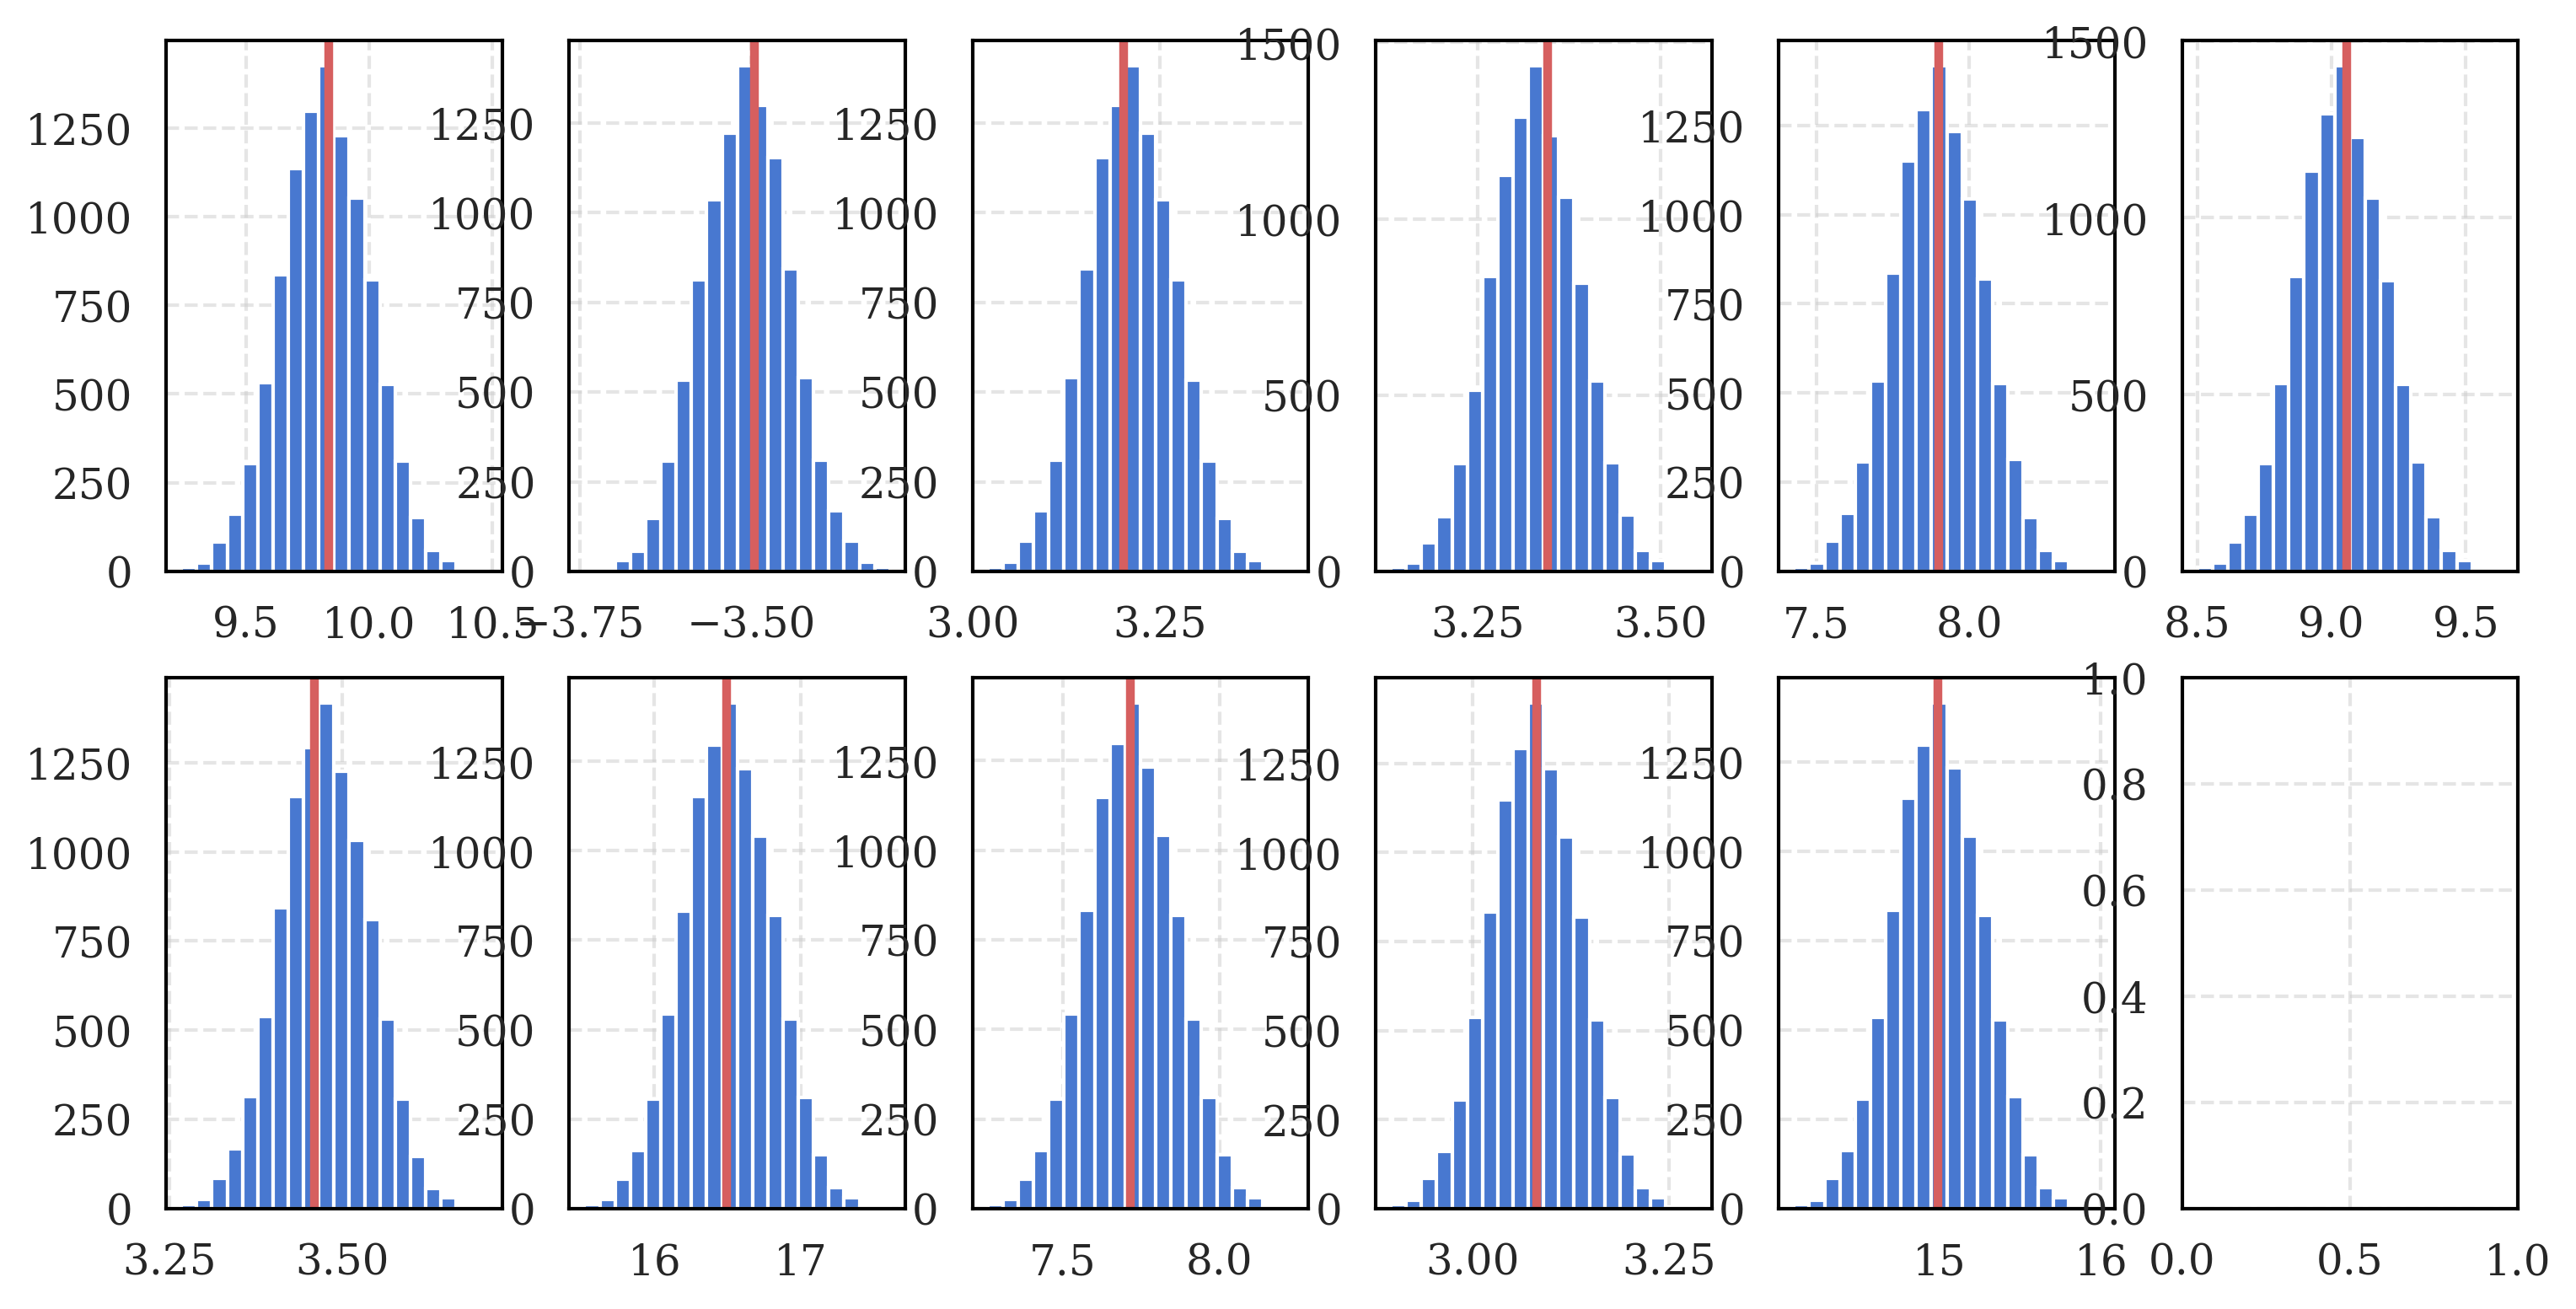

In [11]:
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
grads_estim = []
exact_gradient = true_gradient_mean(x_adv, model, 3)

for _ in range(10000):
    rep_gradients, _, _ = reparametrization_trick(x_adv, model, 3, 1000, id)
    grads_estim.append(rep_gradients.clone().numpy())
    x_adv.grad.zero_()
    

# plot histogram of gradients
if dataset == 'energy':
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        axs[i // 4, i % 4].hist(np.array(grads_estim)[:, i], bins=20)
        # plot line at exact_gradient[i]
        axs[i // 4, i % 4].axvline(exact_gradient[i].item(), color='r')

if dataset == 'wine':
    fig, axs = plt.subplots(2, 6, figsize=(12, 6))
    for i in range(11):
        axs[i // 6, i % 6].hist(np.array(grads_estim)[:, i], bins=20)
        # plot line at exact_gradient[i]
        axs[i // 6, i % 6].axvline(exact_gradient[i].item(), color='r')


In [12]:
def attack(x_clean, model, G, samples_per_iteration=1000, learning_rate=1e-3, num_iterations=1000, epsilon=.1, func=id, early_stopping_patience=10):
    x_0 = x_clean.clone().detach()
    x_adv = x_clean.clone().detach().requires_grad_(True)
    x_adv_values = []
    loss_values = []
    func_values = []
    early_stopping_it = 0

    optimizer = torch.optim.SGD([x_adv], lr=learning_rate)

    for _ in range(num_iterations):
        x_adv.requires_grad = True
        old_x_adv = x_adv.clone().detach()

        _, f_mean, loss = reparametrization_trick(x_adv, model, G, samples_per_iteration, func=func)

        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x_0, p=2) > epsilon:
                x_adv = x_0 + epsilon * (x_adv - x_0) / torch.norm(x_adv - x_0, p=2)

        # Early stopping
        if torch.norm(x_adv - old_x_adv, p=2) < 1e-5:
            early_stopping_it += 1
            if early_stopping_it > early_stopping_patience:
                break
        else:
            early_stopping_it = 0            
        x_adv_values.append(x_adv.clone().detach().numpy())
        loss_values.append(loss.item())
        func_values.append(f_mean.item())

    return x_adv_values, loss_values, func_values

In [13]:
def attack_true_grad(x_clean, model, G, samples_per_iteration=1000, learning_rate=1e-1, num_iterations=1000, epsilon=.1, func=id, early_stopping_patience=10):
    x_0 = x_clean.clone().detach()
    x_adv = x_clean.clone().detach().requires_grad_(True)
    x_adv_values = []
    # early_stopping_it = 0

    optimizer = torch.optim.SGD([x_adv], lr=learning_rate)

    for _ in range(num_iterations):
        x_adv.requires_grad = True
        # old_x_adv = x_adv.clone().detach()

        x_adv.grad = true_gradient_mean(x_adv, model, G)
        optimizer.step()
        x_adv.grad.zero_()
        # print(torch.norm((x_adv - x_0) / torch.norm(x_adv - x_0, p=2) - model.mu / torch.norm(model.mu, p=2)))
        with torch.no_grad():
            if torch.norm(x_adv - x_0, p=2) > epsilon:
                x_adv = x_0 + epsilon * (x_adv - x_0) / torch.norm(x_adv - x_0, p=2)

        # Early stopping
        # if torch.norm(x_adv - old_x_adv, p=2) < 1e-5:
        #     early_stopping_it += 1
        #     if early_stopping_it > early_stopping_patience:
        #         break
        # else:
        #     early_stopping_it = 0            
        # print(torch.norm((x_adv - x_0) / torch.norm(x_adv - x_0, p=2) - model.mu / torch.norm(model.mu, p=2)))
        x_adv_values.append(x_adv.clone().detach().numpy())
    # print(torch.norm((x_adv - x_0) / torch.norm(x_adv - x_0, p=2) - model.mu / torch.norm(model.mu, p=2)))
    return x_adv_values

In [14]:
def attack_fgsm(x_clean, model, G, samples_per_iteration=1000, learning_rate=1e-3, num_iterations=1000, epsilon=.1, func=id, early_stopping_patience=10):
    x_0 = x_clean.clone().detach()
    x_adv = x_clean.clone().detach().requires_grad_(True)

    optimizer = torch.optim.SGD([x_adv], lr=learning_rate)

    x_adv.requires_grad = True

    _, f_mean, loss = reparametrization_trick(x_adv, model, G, samples_per_iteration, func=func)
    x_adv.grad = x_adv.grad.sign()
    optimizer.step()
    x_adv.grad.zero_()
    
    with torch.no_grad():
        x_adv = x_0 + epsilon * (x_adv - x_0) / torch.norm(x_adv - x_0, p=2)

    return x_adv

## Attack with mean as objective function

In [15]:
def det_attack(x_adv, model, y_star, epsilon=.1, verbose=False):
    mu = model.mu.numpy()

    beta_dot_x = np.dot(mu, x_adv)
    beta_norm_squared = np.dot(mu, mu)
    x_adv_det = x_adv + ((y_star - beta_dot_x) / beta_norm_squared) * mu

    if np.linalg.norm(np.dot(y_star - beta_dot_x, mu)) > epsilon * beta_norm_squared: 
        if verbose:
            print('Optimal perturbation is too large')
        delta_x_adv = epsilon * (np.dot(y_star - beta_dot_x, mu) / (np.linalg.norm(y_star - beta_dot_x) * np.linalg.norm(mu)))
        x_adv_det = x_adv + delta_x_adv

    y_adv_det = np.dot(mu, x_adv_det)
    return x_adv_det, y_adv_det

Text(0, 0.5, 'Function value')

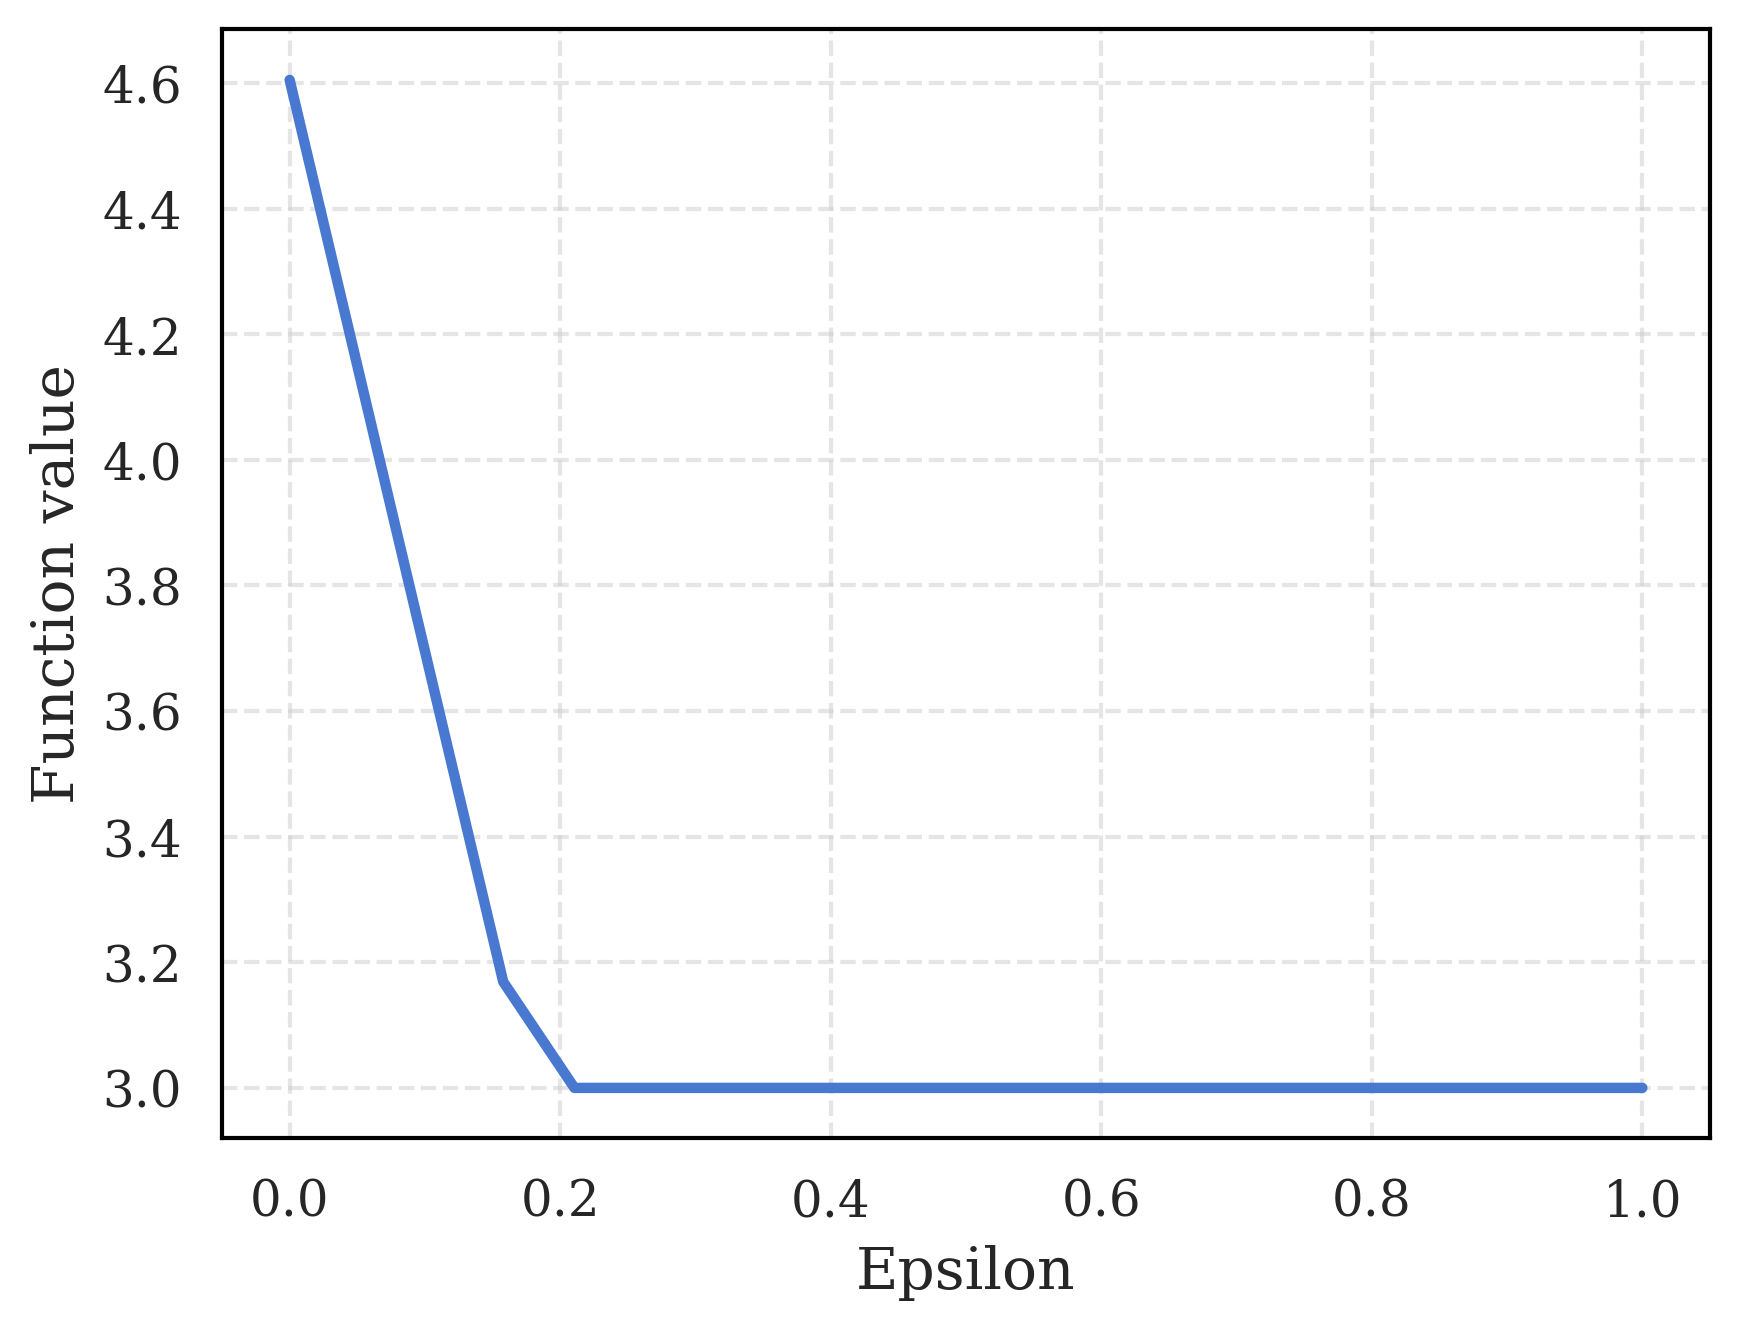

In [16]:
x_adv = X_test[17,:].copy()
y_star = 3
epsilon = .2

# Plot function value against strength of attack
epsilons = np.linspace(0, 1, 20)
func_values = []

for epsilon in epsilons:
    x_adv_det, y_adv_det = det_attack(x_adv, model, y_star, epsilon)
    func_values.append(y_adv_det)

plt.plot(epsilons, func_values)
plt.xlabel('Epsilon')
plt.ylabel('Function value')

In [17]:
y_star = 3
epsilon = .2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, early_stopping_patience=50)
x_adv_rep = x_adv_values[-1]

Text(0, 0.5, 'Loss')

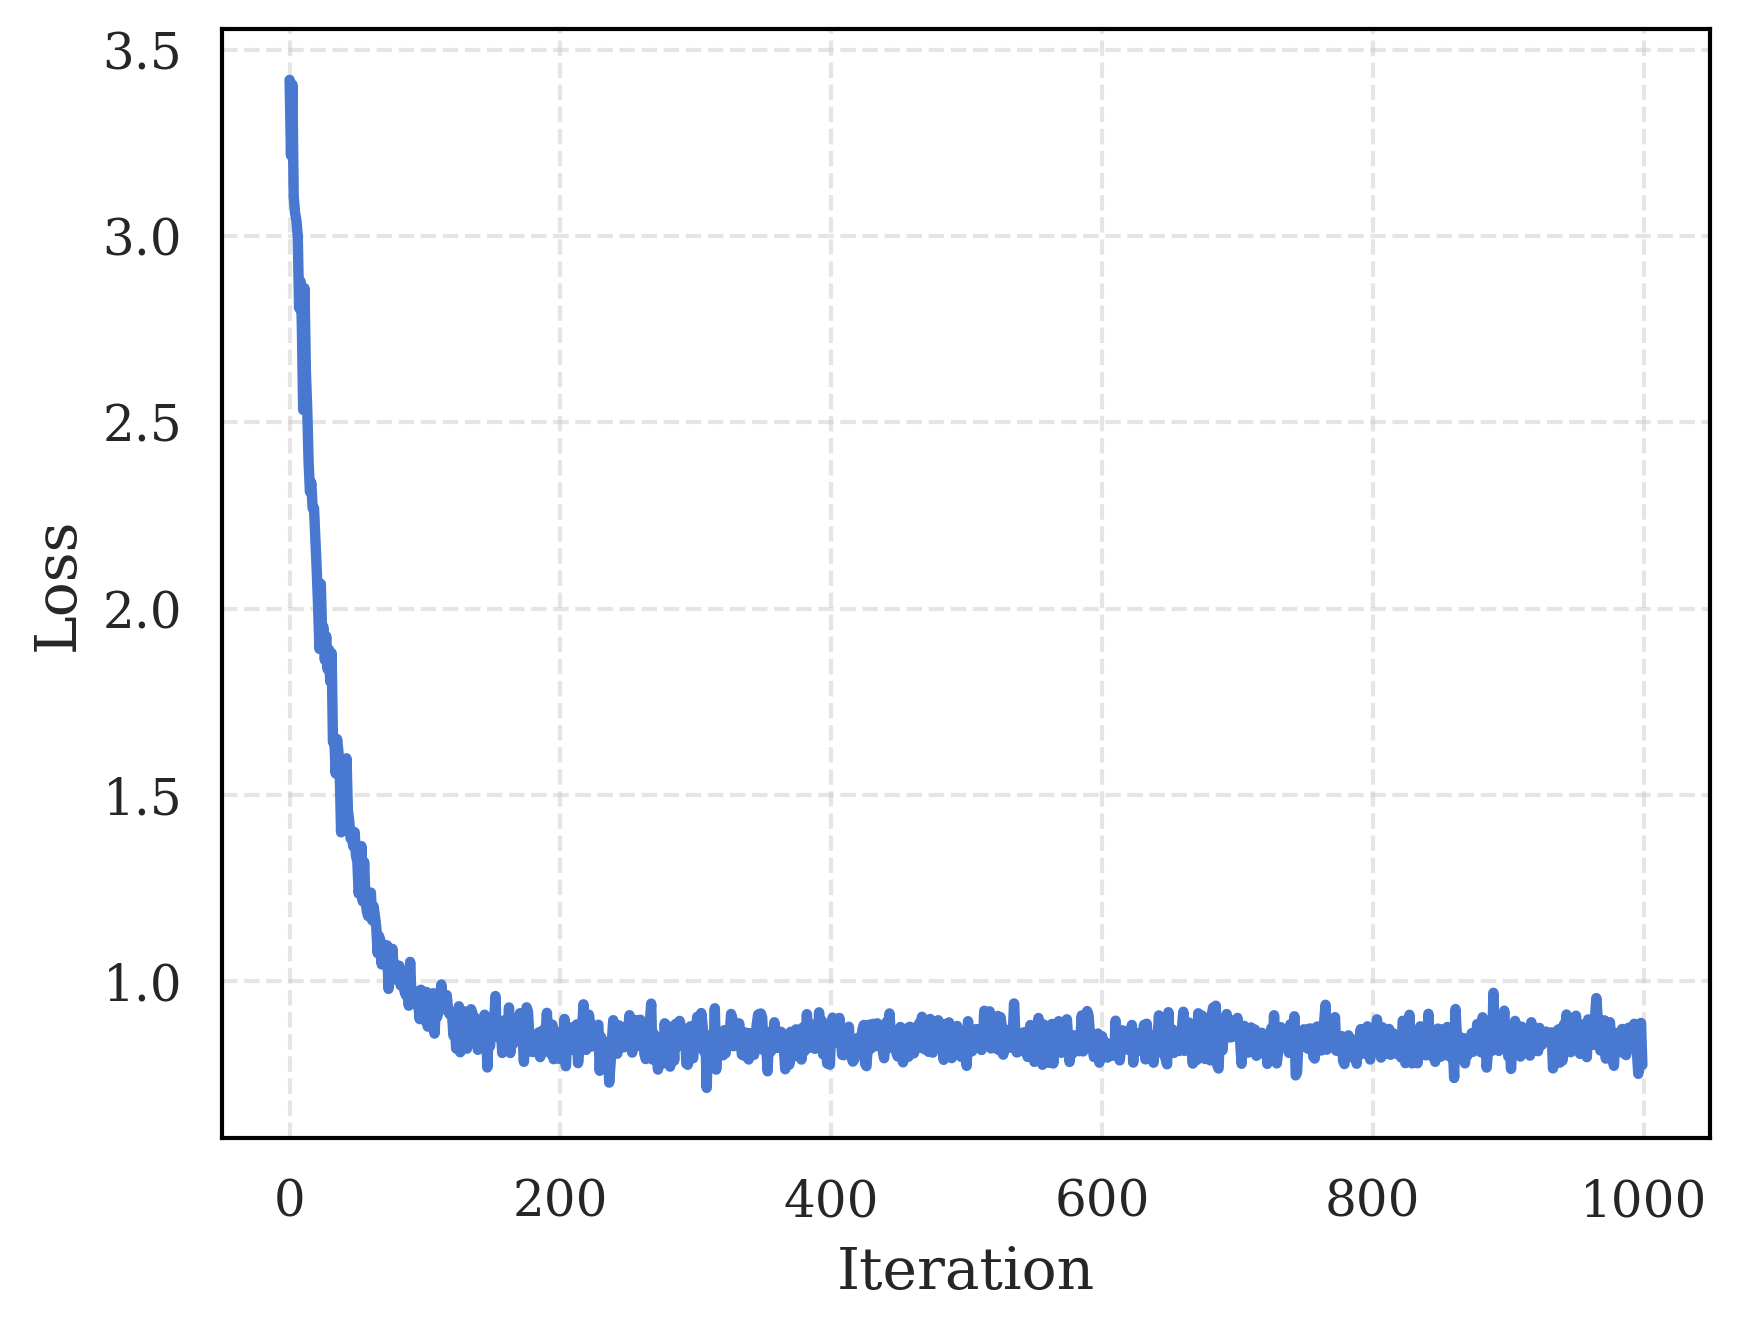

In [18]:
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Function value')

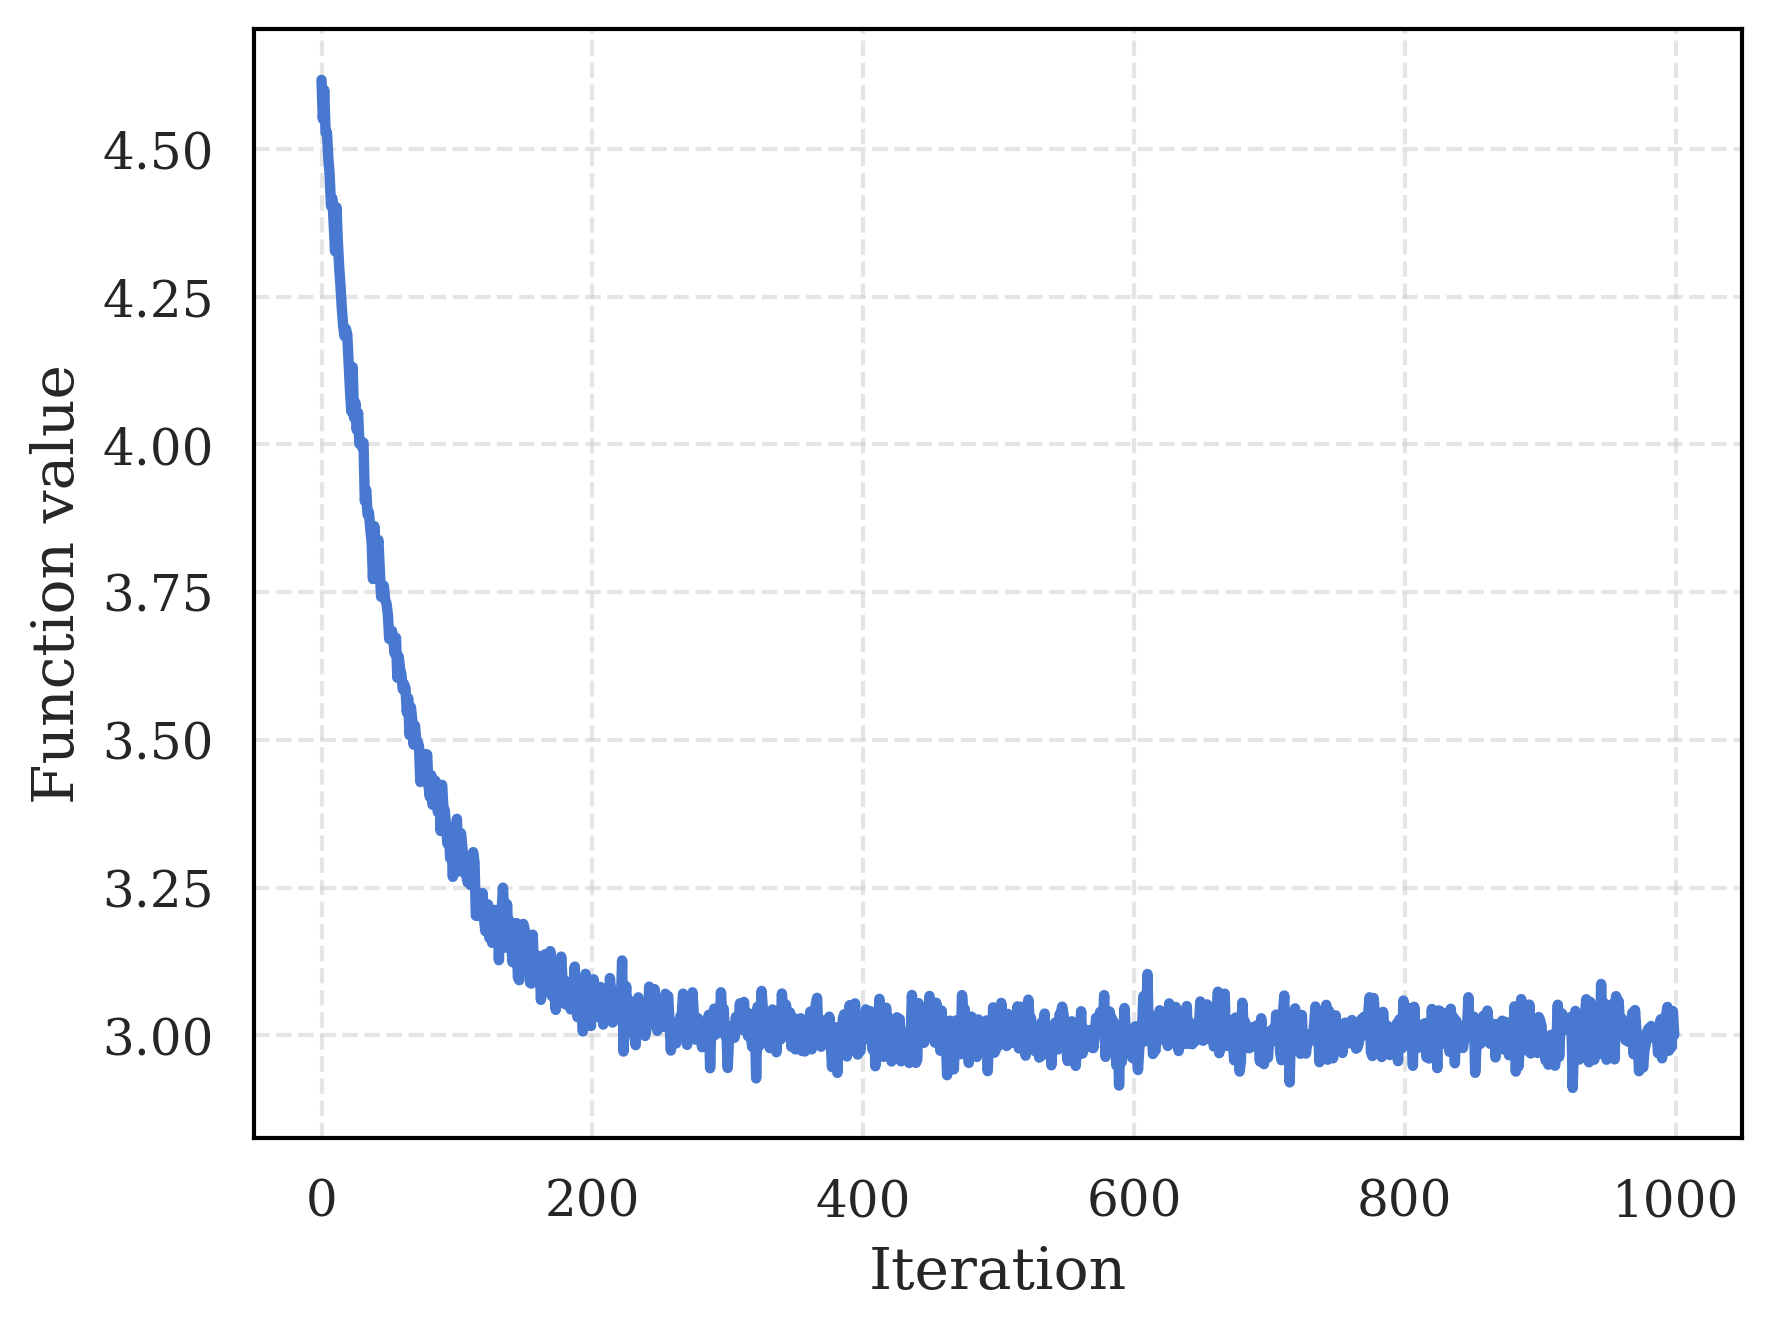

In [19]:
plt.plot(func_values)
plt.xlabel('Iteration')
plt.ylabel('Function value')

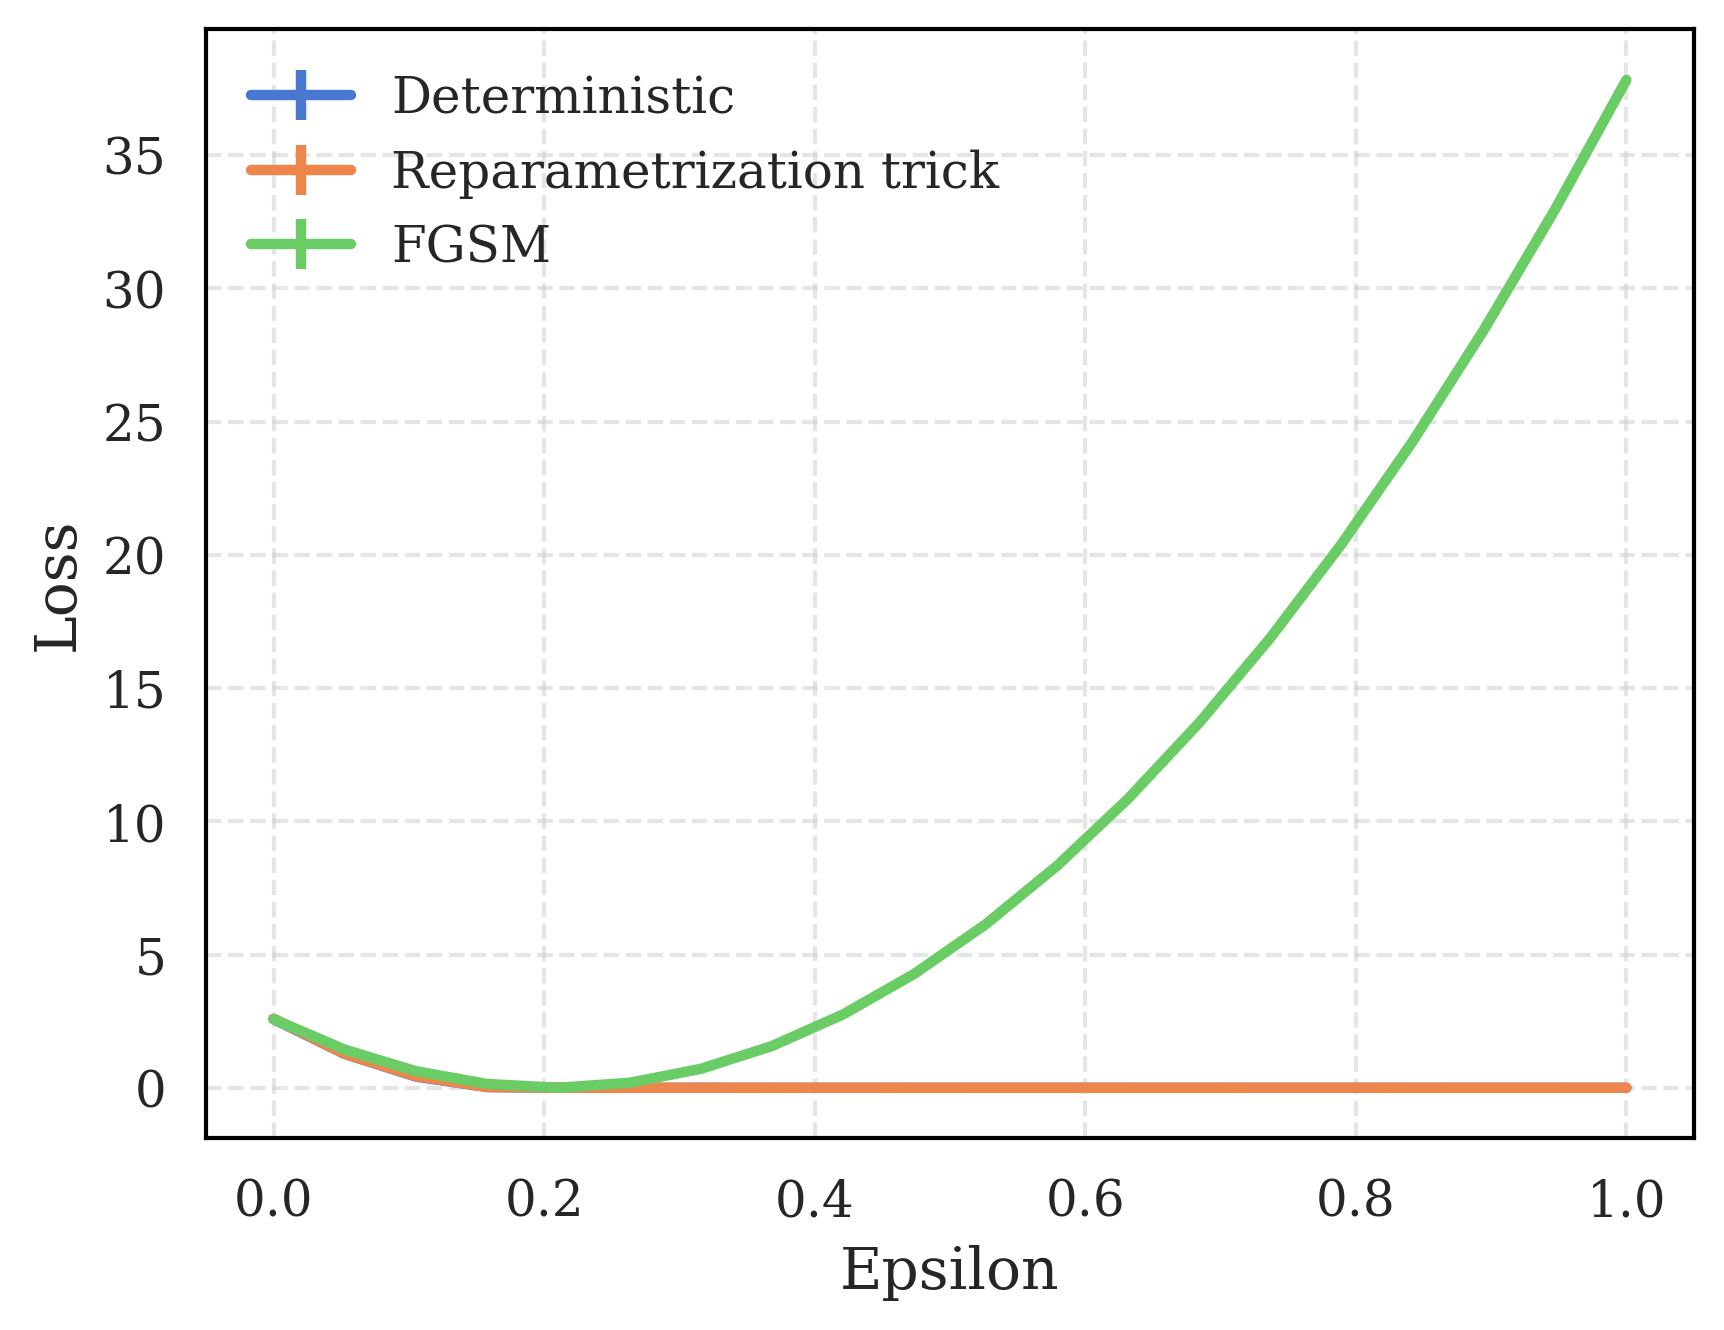

In [20]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
losses_det_all = []
losses_rep_all = []
losses_fgsm_all = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    losses_det = []
    losses_rep = []
    losses_fgsm = []

    for epsilon in epsilons:
        x_adv_det, y_adv_det = det_attack(X_test[17,:].copy(), model, y_star, epsilon, verbose=False)
        losses_det.append((y_adv_det - y_star) ** 2)

        x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, func=id)    
        losses_rep.append((func_values[-1] - y_star) ** 2)

        x_adv_fgsm = attack_fgsm(torch.tensor(X_test[17,:].copy(), dtype=torch.float32), model, y_star, epsilon=epsilon)
        y_adv_fgsm = model.mu @ x_adv_fgsm
        losses_fgsm.append((y_adv_fgsm - y_star) ** 2)

    losses_det_all.append(losses_det)
    losses_rep_all.append(losses_rep)
    losses_fgsm_all.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_det_all, axis=0), yerr=2*np.std(losses_det_all, axis=0), label='Deterministic')
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_fgsm_all, axis=0), yerr=2*np.std(losses_fgsm_all, axis=0), label='FGSM')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.legend()

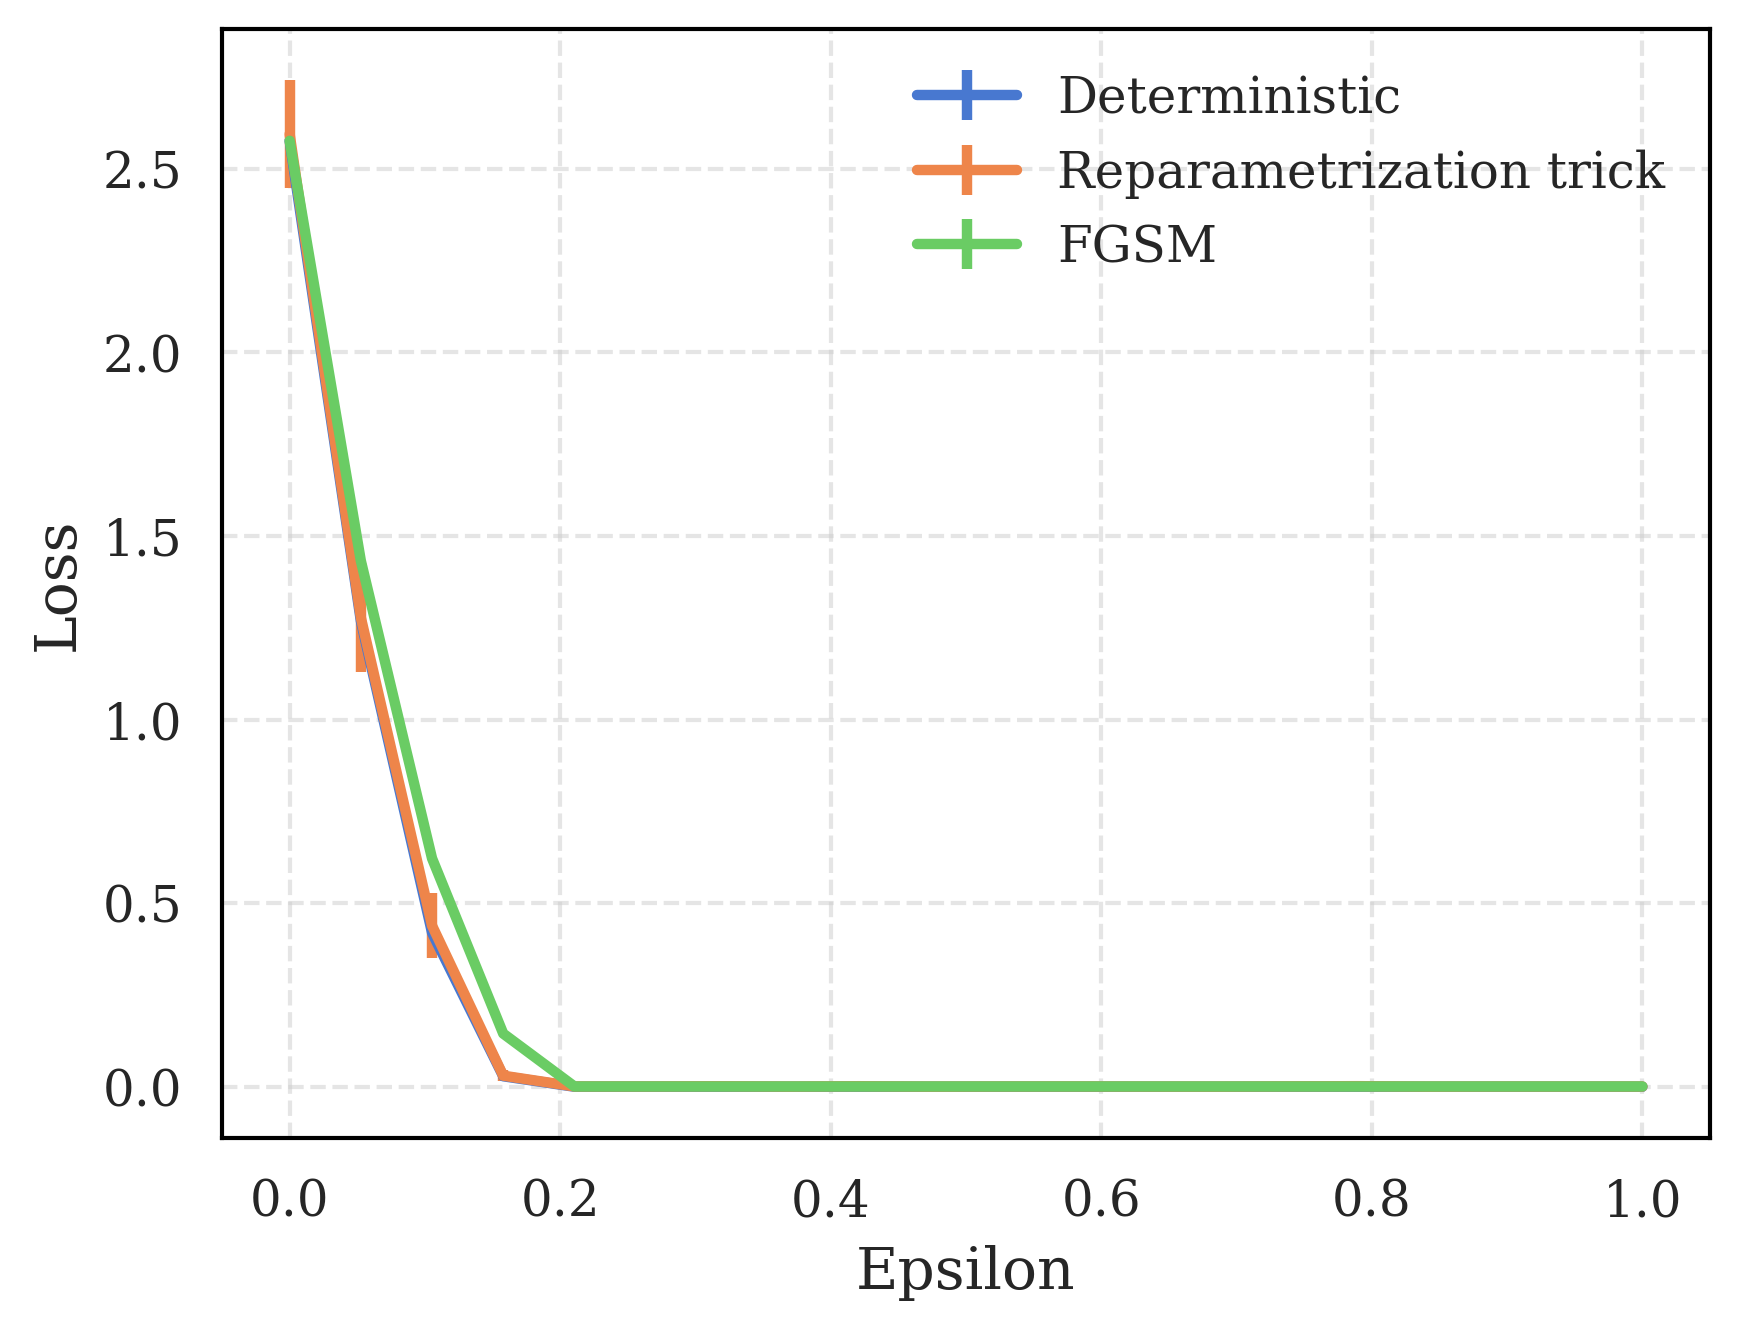

In [21]:
fgsms = np.mean(losses_fgsm_all, axis=0)
for i in range(1, len(fgsms)):
    if fgsms[i] > fgsms[i-1]:
        fgsms[i] = fgsms[i-1]
plt.errorbar(epsilons, np.mean(losses_det_all, axis=0), yerr=2*np.std(losses_det_all, axis=0), label='Deterministic')
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, fgsms, yerr=2*np.std(losses_fgsm_all, axis=0), label='FGSM')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.legend()

## Attack with exp(y^2/100) as objective function

In [22]:
y_star = 3
epsilon = .2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, learning_rate= 1e-2, samples_per_iteration=1000, num_iterations=100, epsilon=epsilon, func=expy2)

Text(0, 0.5, 'Loss')

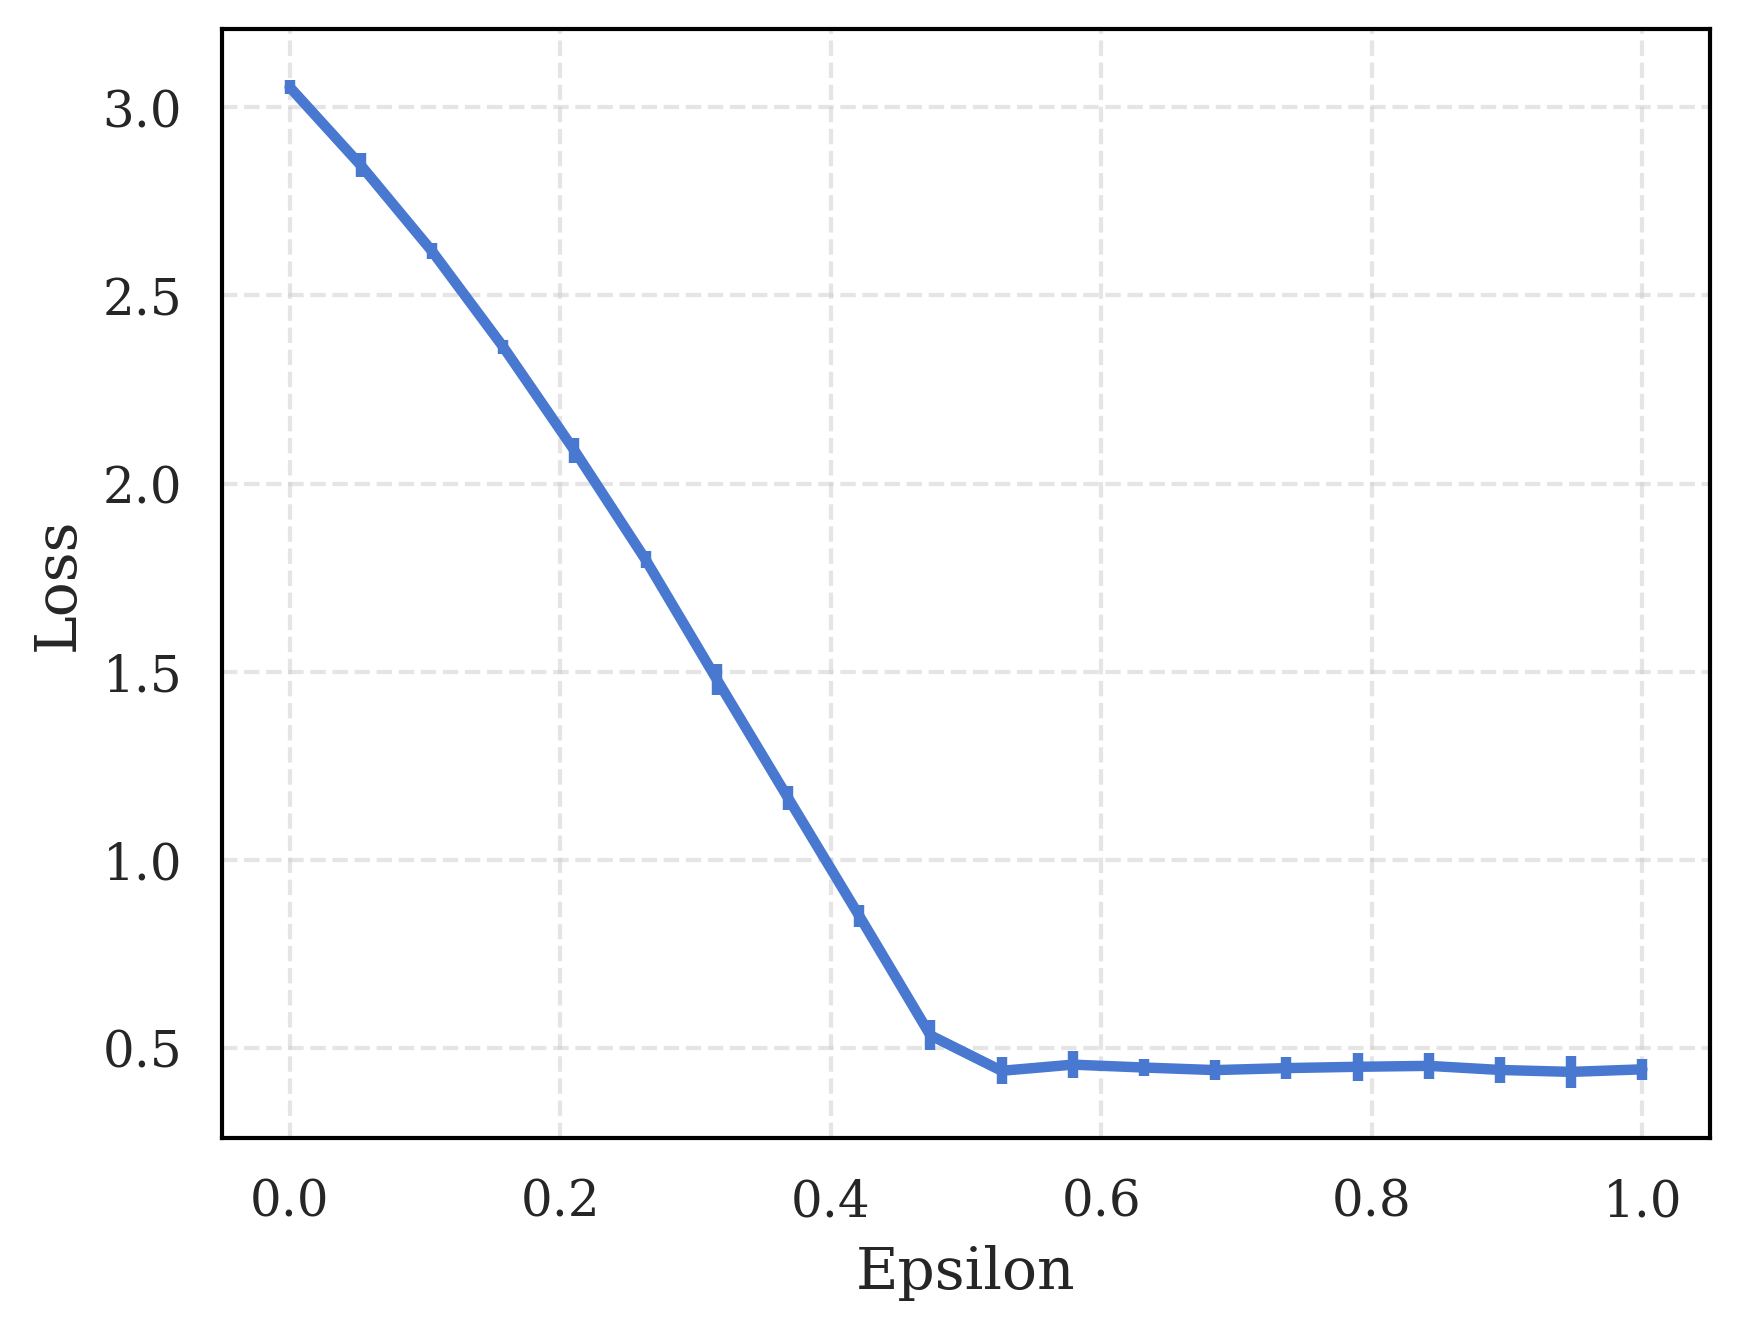

In [23]:
# Plot loss as a function of the size of the perturbation for reparametrization trick attack
losses_total = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    losses_rep = []

    for epsilon in epsilons:
        x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2)    
        losses_rep.append((func_values[-1] - y_star) ** 2)

    losses_total.append(losses_rep)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_total, axis=0), yerr=2*np.std(losses_total, axis=0))
plt.xlabel('Epsilon')
plt.ylabel('Loss')

## Variance as objective

In [24]:
y_star = 30
epsilon = 2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

def var(x, y):
    return torch.var(y)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, learning_rate= 1e-2, samples_per_iteration=1000, num_iterations=100, epsilon=epsilon, func=var)

Text(0.5, 0, 'y')

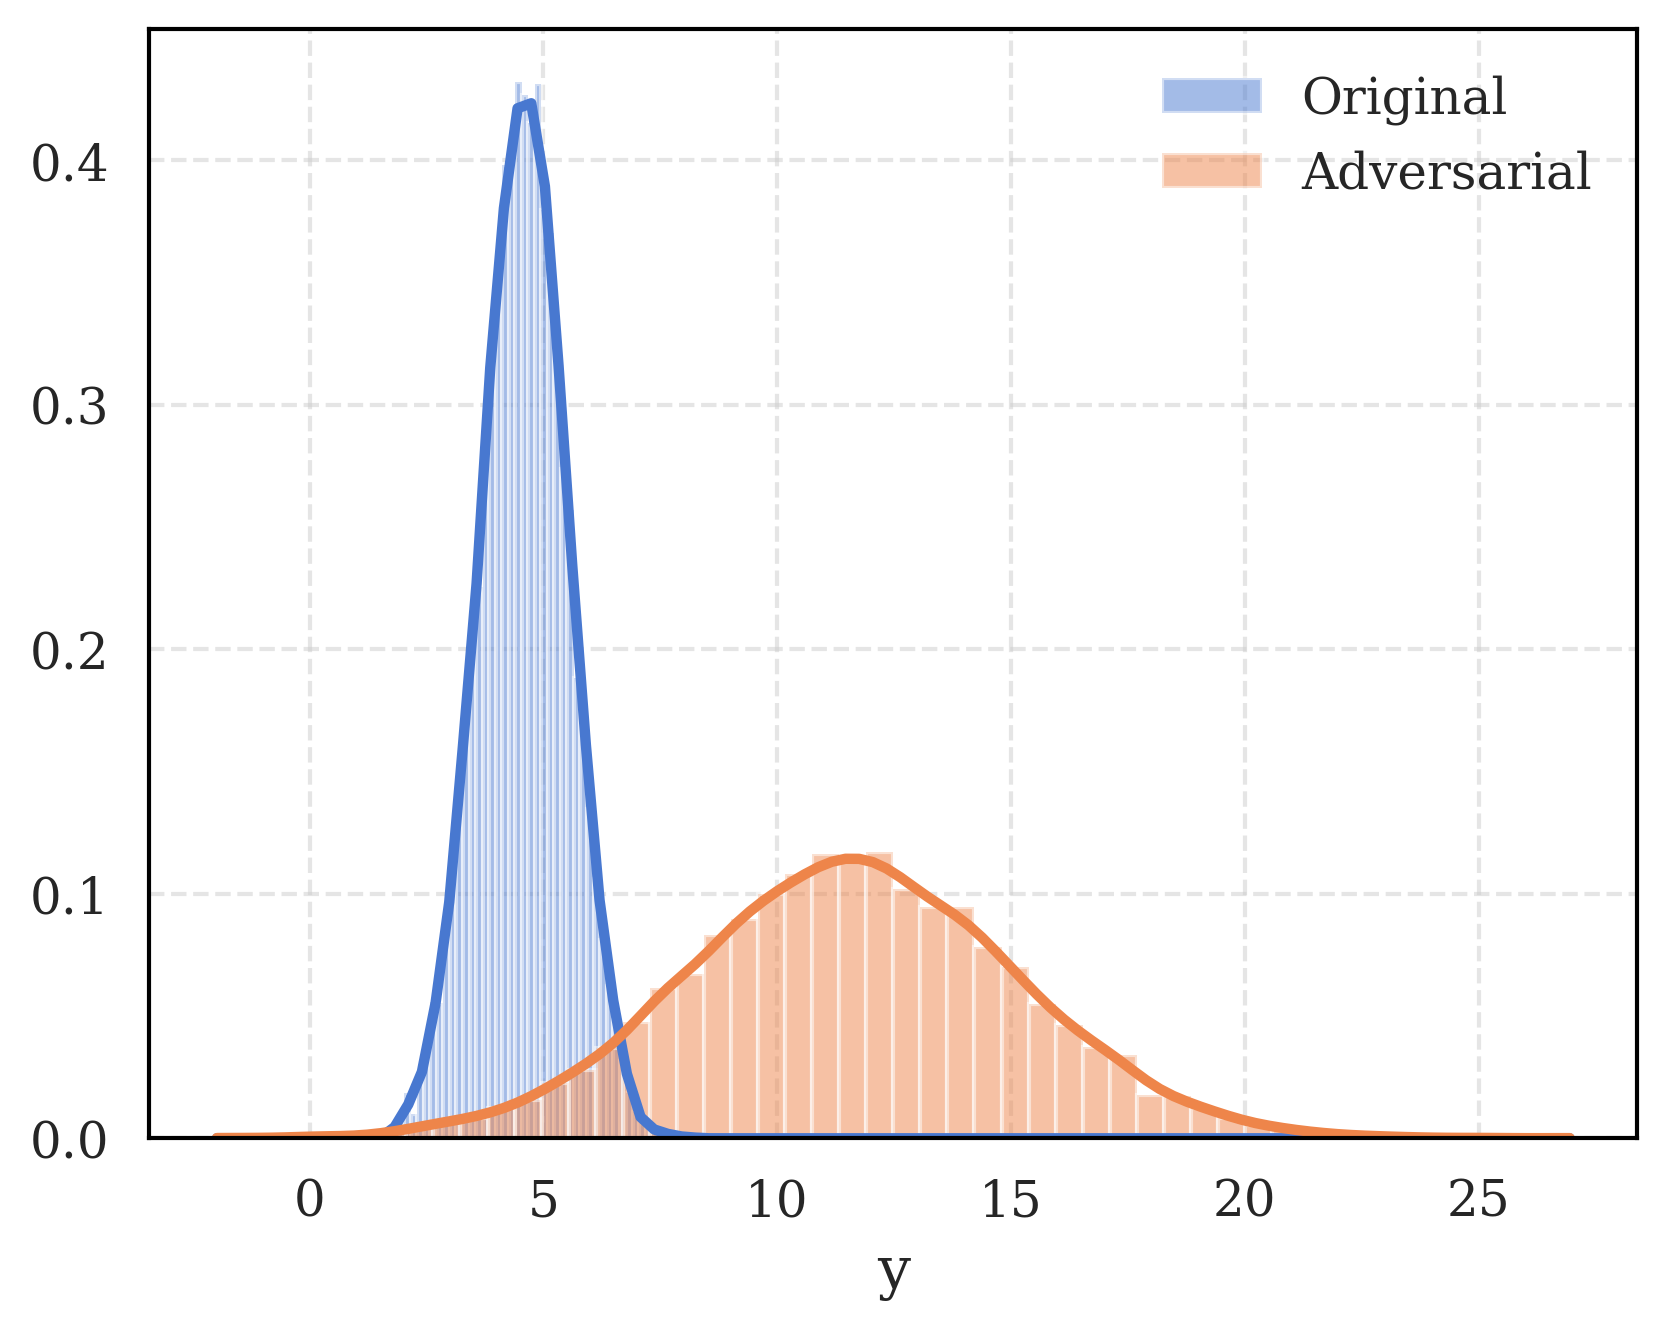

In [25]:
y_samples = model.sample_predictive_distribution(x_adv.unsqueeze(1), num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(
    torch.tensor(x_adv_values[-1], dtype=torch.float32).unsqueeze(1), num_samples=10000).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.legend()
plt.xlabel('y')

## Vector field of perturbations for toy dataset

In [26]:
# Toy data
X, y = get_toy_data()

In [27]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [28]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Text(0, 0.5, 'Counts')

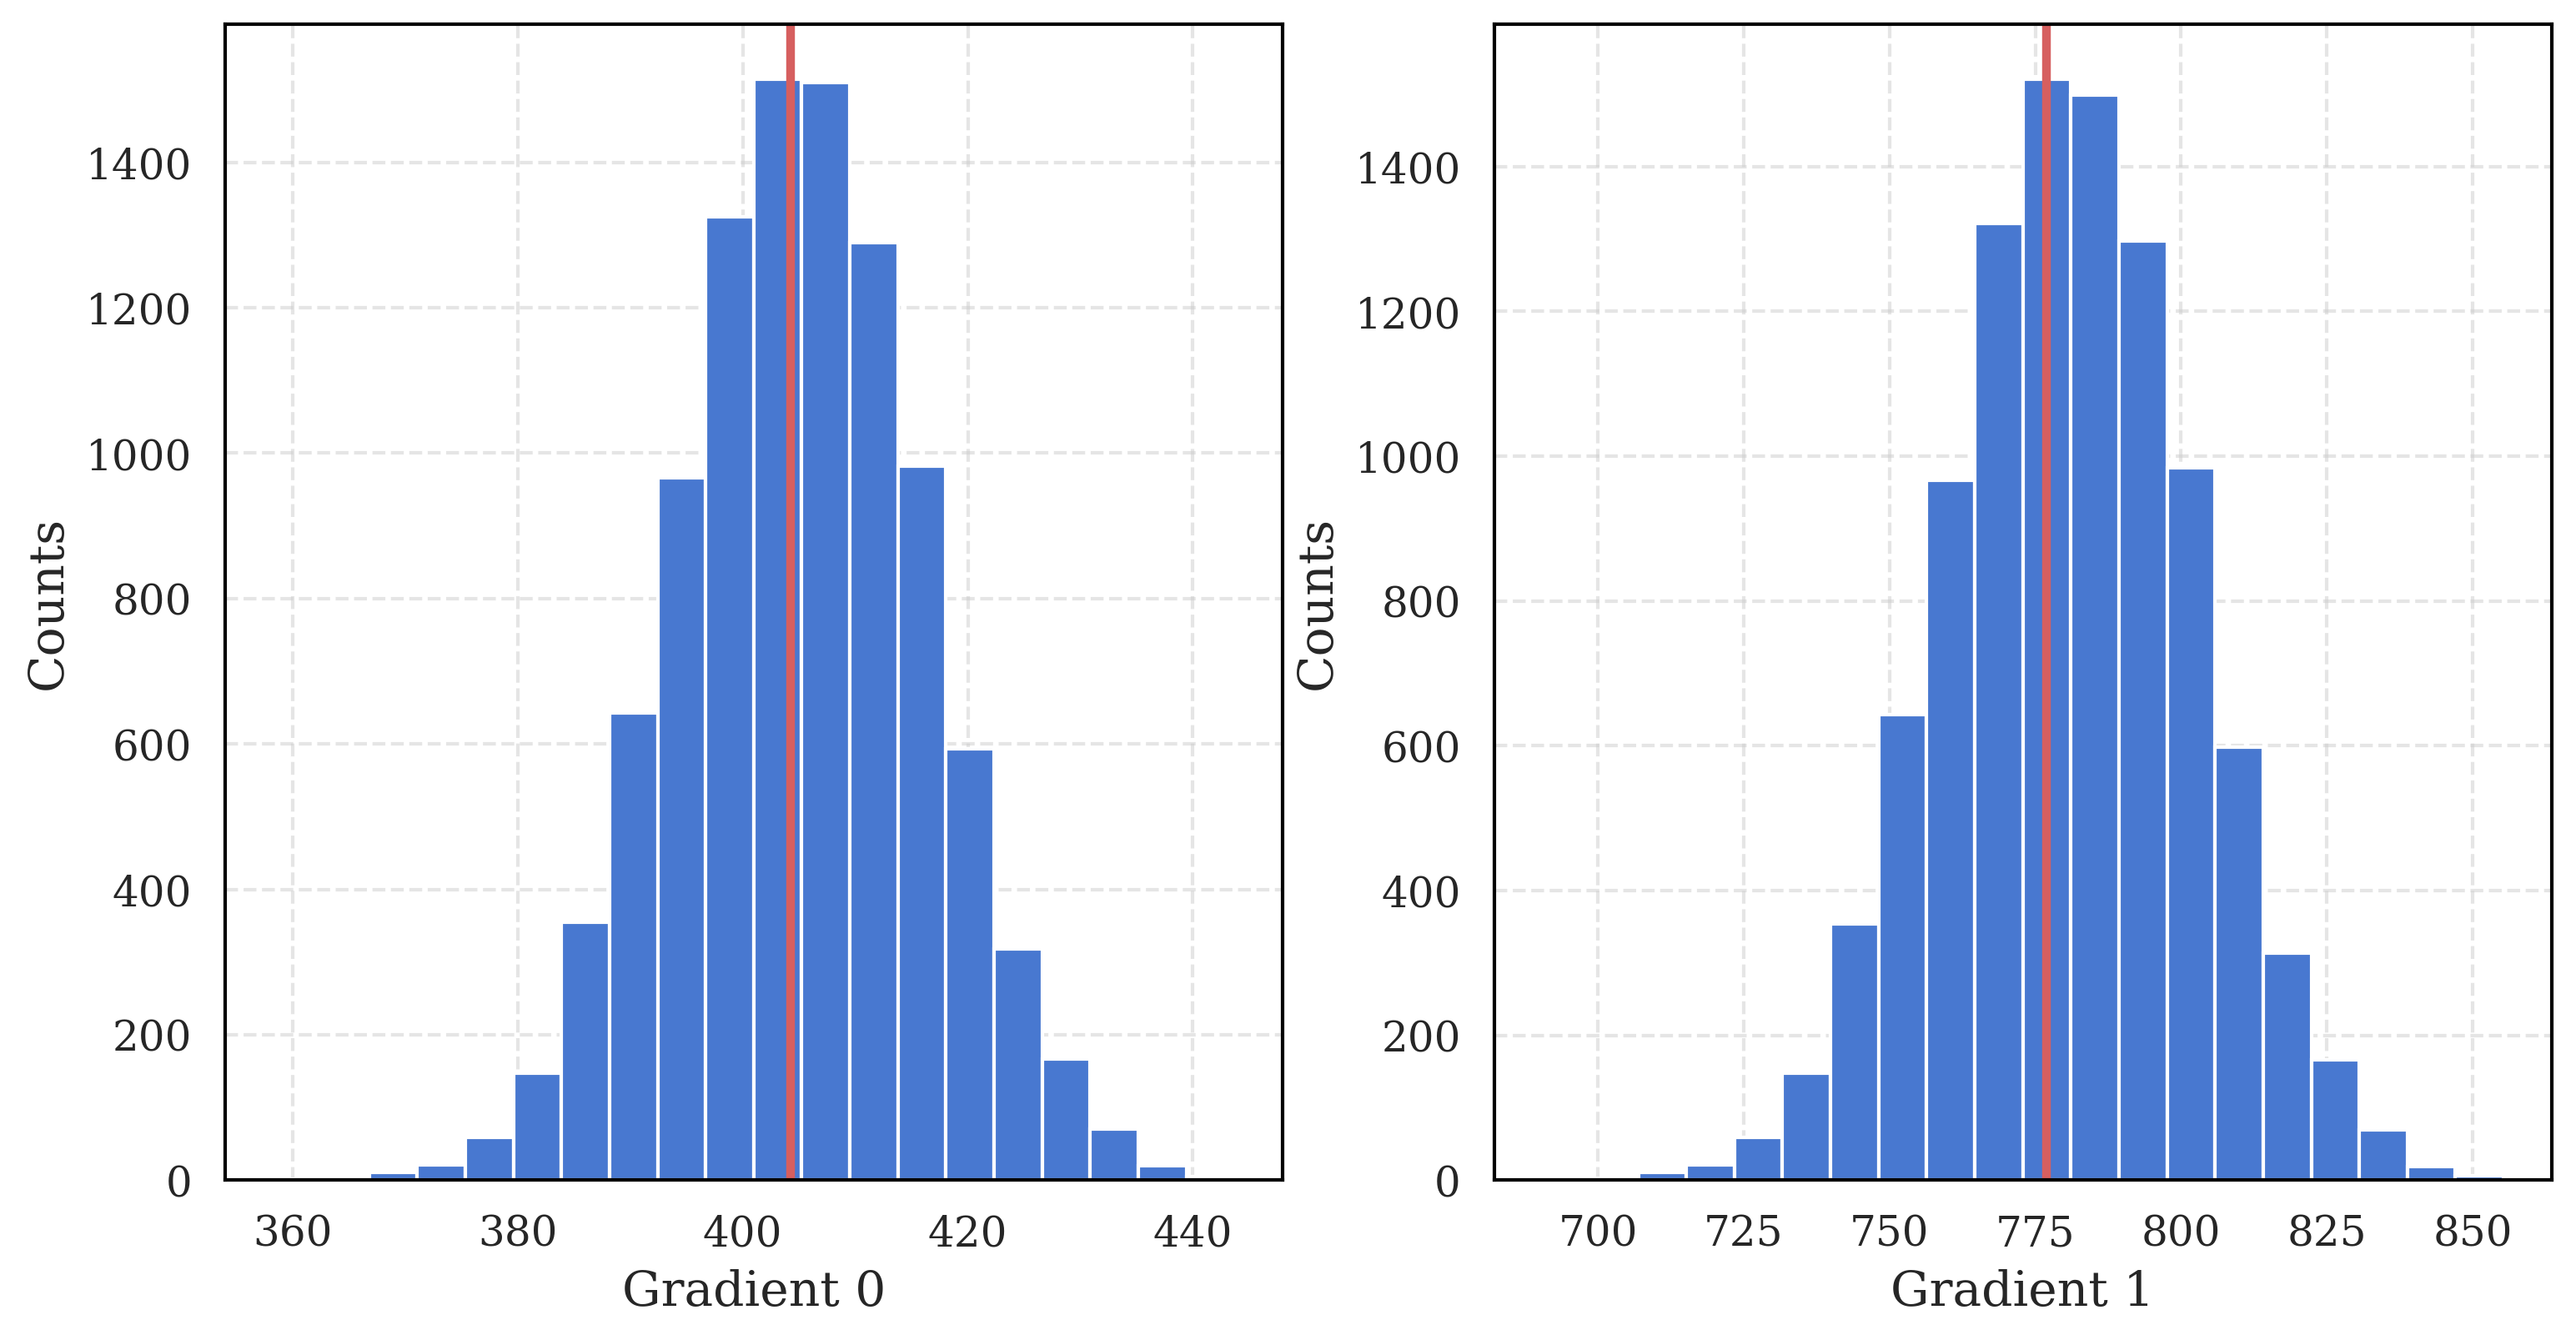

In [29]:
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
grads = []
exact_gradient = true_gradient_mean(x_adv, model, 3)

for _ in range(10000):
    rep_gradients, _, _ = reparametrization_trick(x_adv, model, 3, 1000, id)
    grads.append(rep_gradients.clone().numpy())
    x_adv.grad.zero_()
    

# plot histogram of gradients
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(np.array(grads)[:, 0], bins=20)
# plot line at exact_gradient[0]
axs[0].axvline(exact_gradient[0].item(), color='r')

axs[1].hist(np.array(grads)[:, 1], bins=20)
# plot line at exact_gradient[1]
axs[1].axvline(exact_gradient[1].item(), color='r')

# label the axes
axs[0].set_xlabel('Gradient 0')
axs[0].set_ylabel('Counts')
axs[1].set_xlabel('Gradient 1')
axs[1].set_ylabel('Counts')

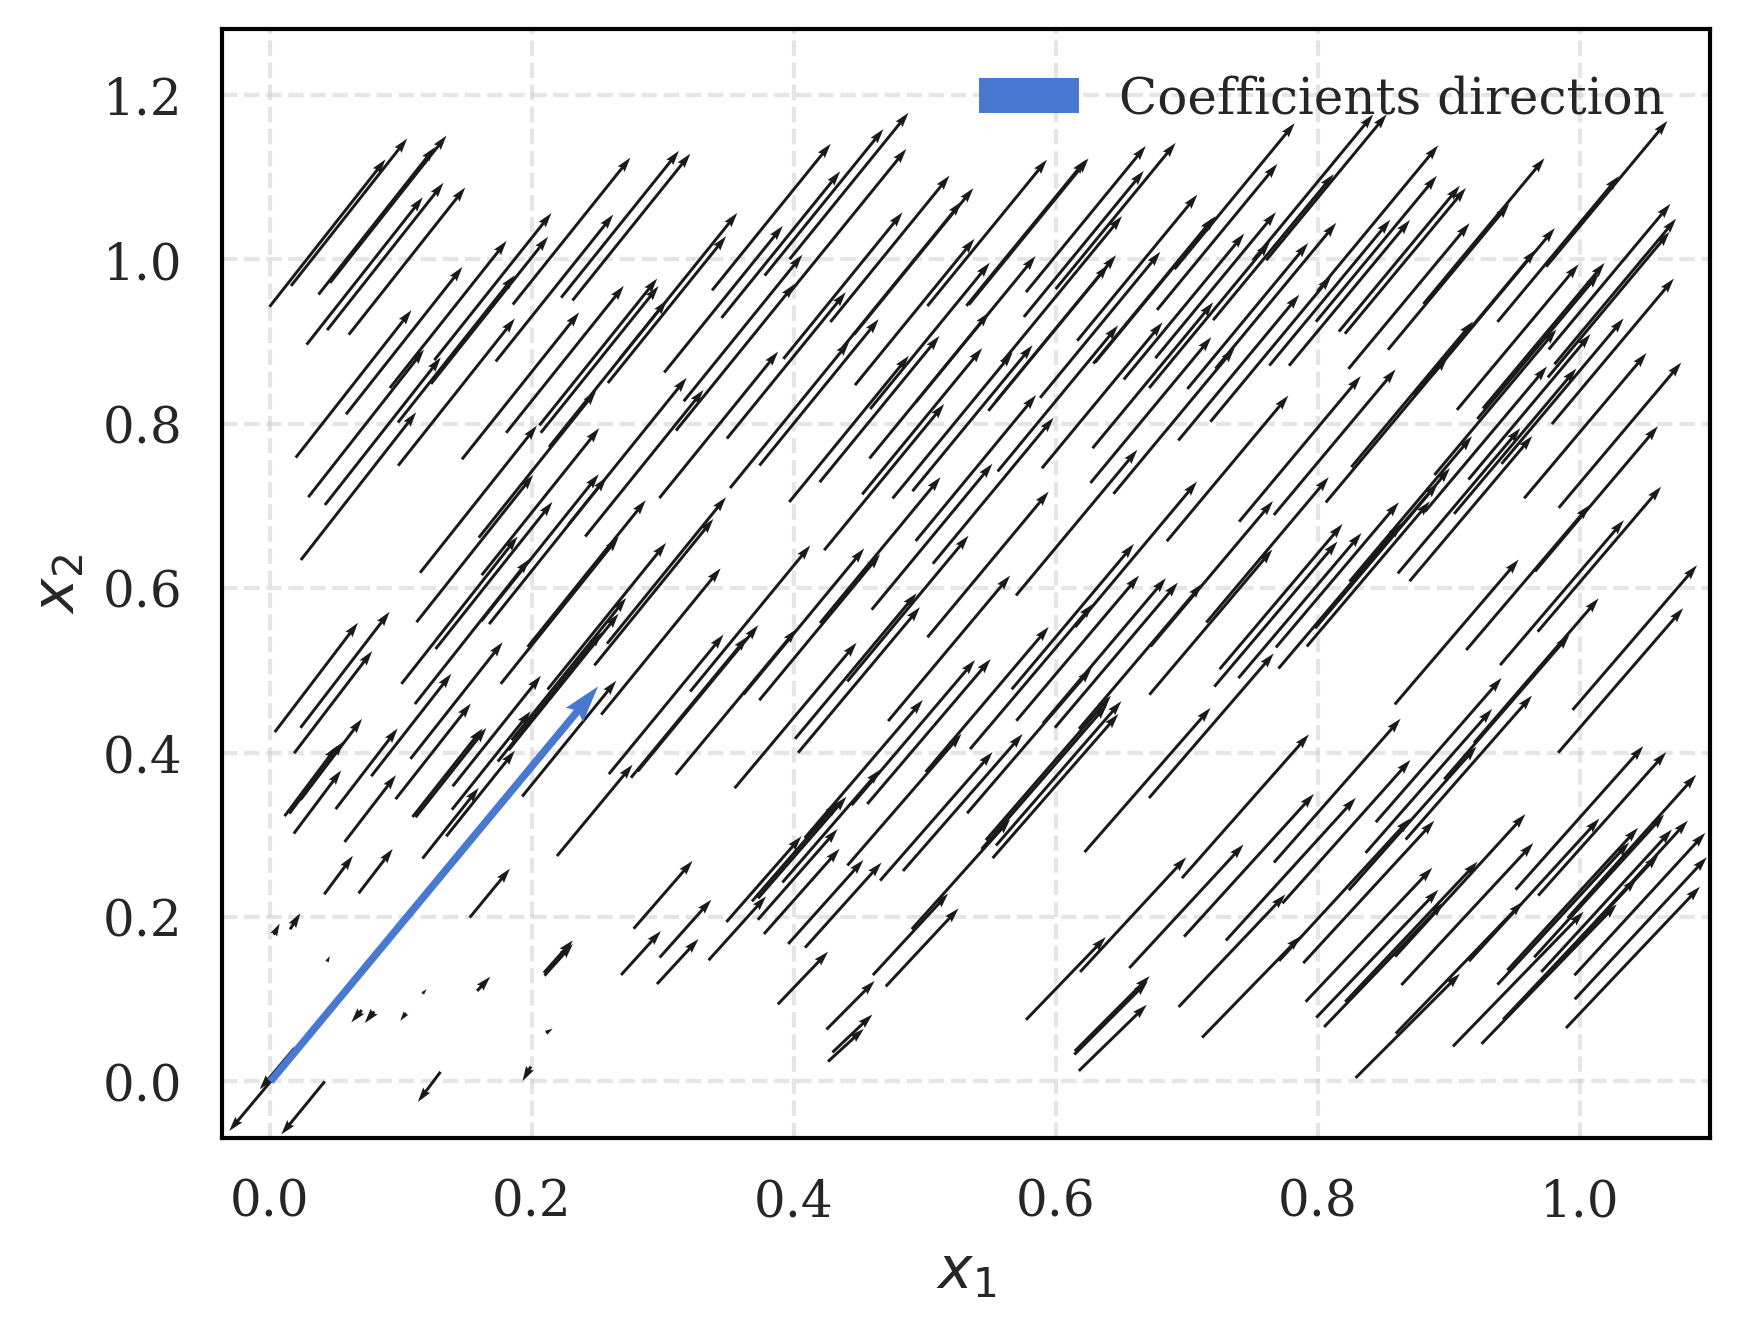

In [30]:
# Vector field of perturbations
y_star = 3
epsilon = .2

perturbations = []

for i in range(X_test.shape[0]):
    x_adv = torch.tensor(X_test[i,:].copy(), dtype=torch.float32, requires_grad=True)
    x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, samples_per_iteration=1000, learning_rate=1e-6, num_iterations=1000, func=id)
    perturbations.append(x_adv.clone().detach().numpy() - x_adv_values[-1])

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Text(103.99999999999999, 0.5, '$x_2$')

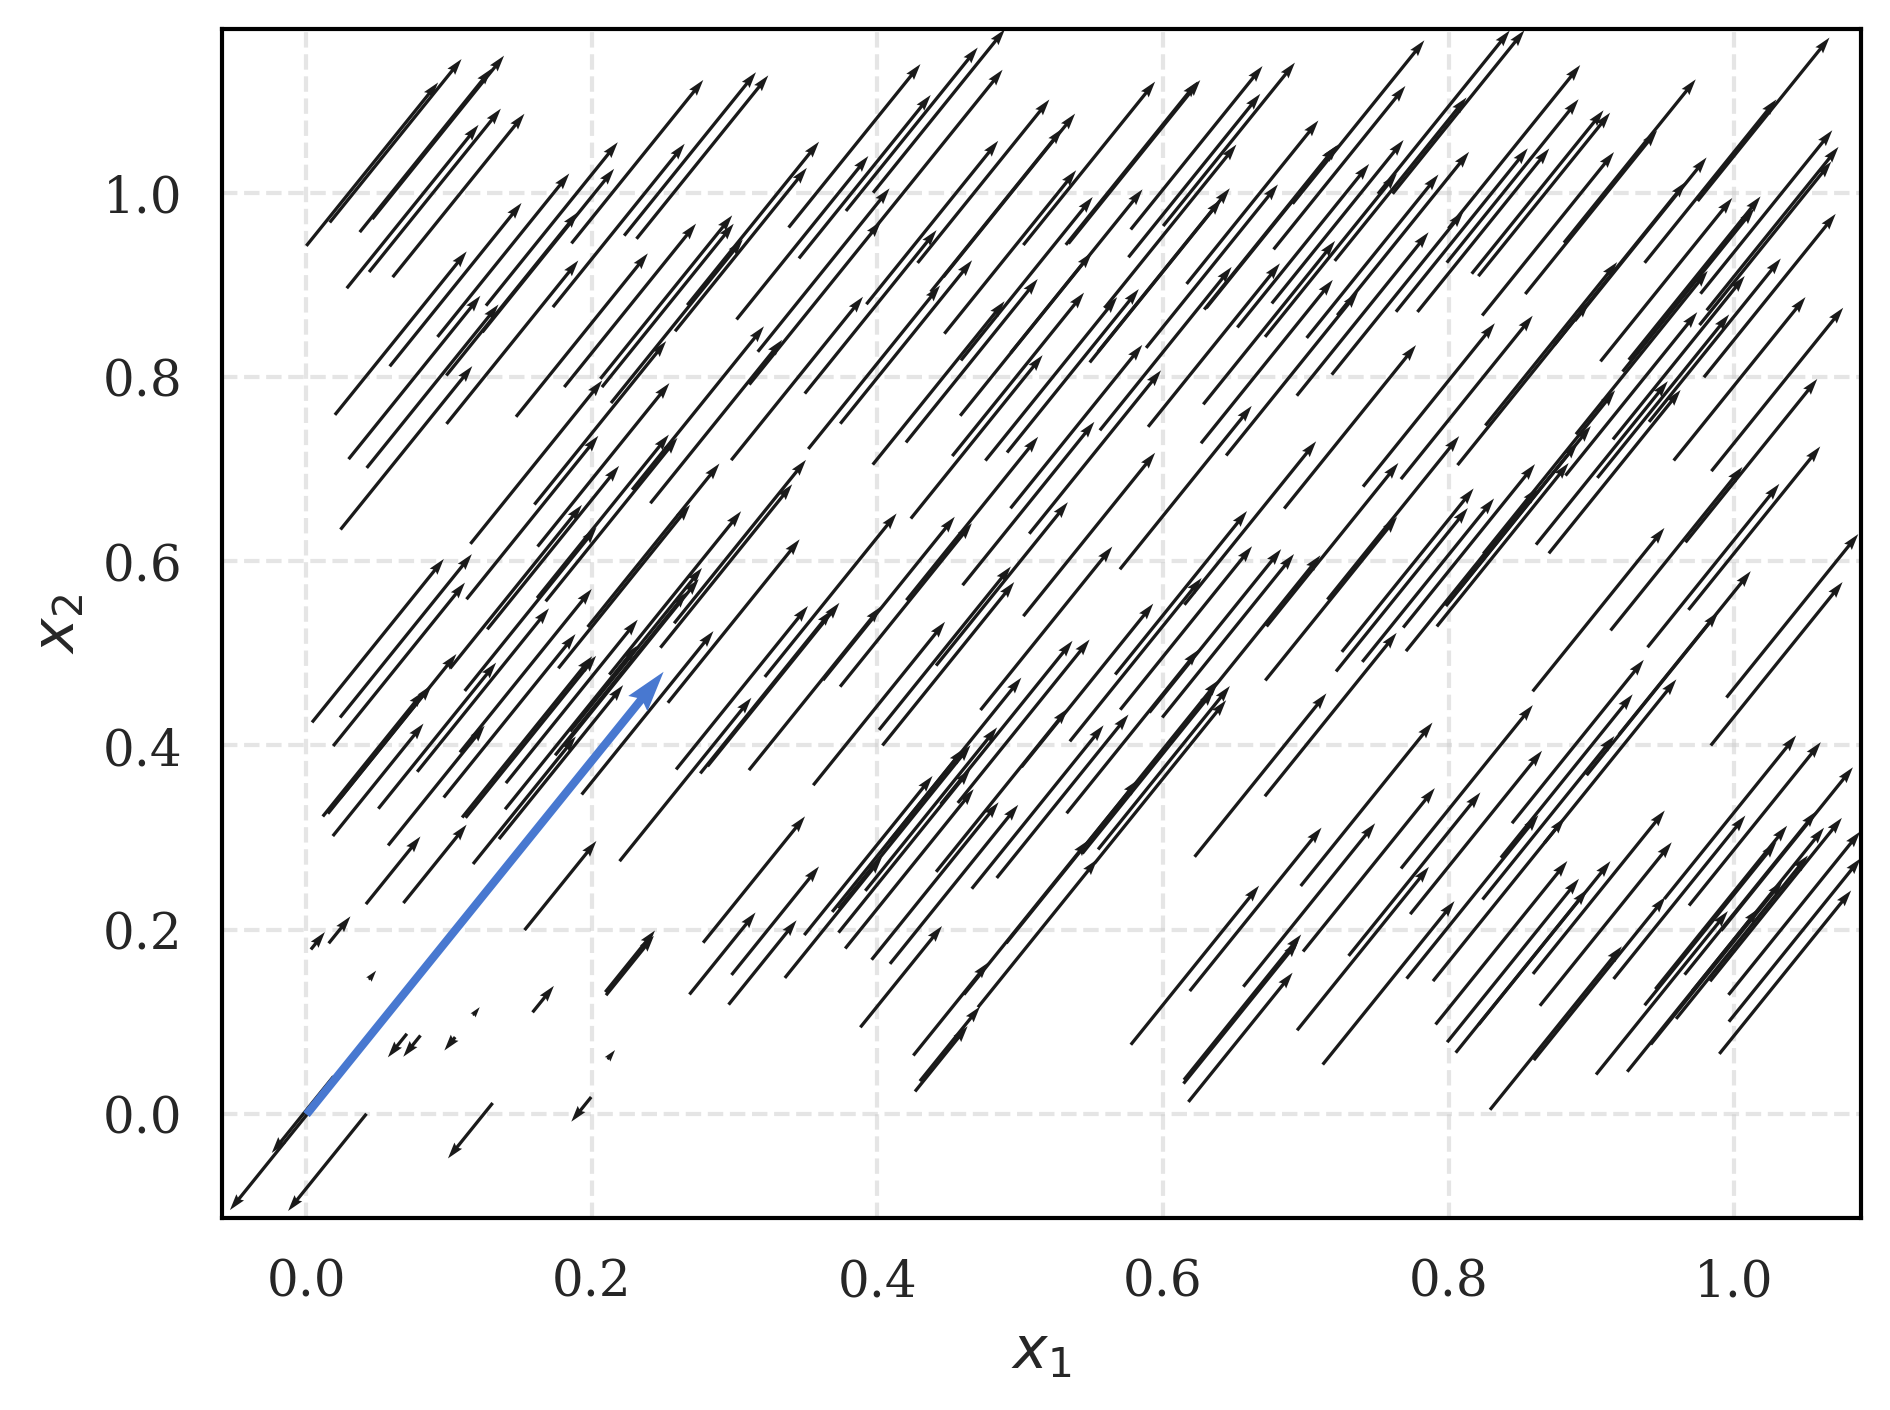

In [31]:
# Vector field of perturbations
y_star = 3
epsilon = .2

perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32)
    x_adv, func_value = det_attack(x, model, y_star, epsilon=epsilon)
    perturbations.append(x.detach() - x_adv)

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]))
plt.tight_layout()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

<!-- ## Attack with y^2 as objective -->